In [3]:
def price_sq(x):
  #if div by 20 then x 50
  return x//50

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                            OLS Regression Results                            
Dep. Variable:             sold_price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     19.84
Date:                Mon, 17 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:46:14   Log-Likelihood:                -50970.
No. Observations:                4000   AIC:                         1.052e+05
Df Residuals:                    2366   BIC:                         1.155e+05
Df Model:                        1633                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--

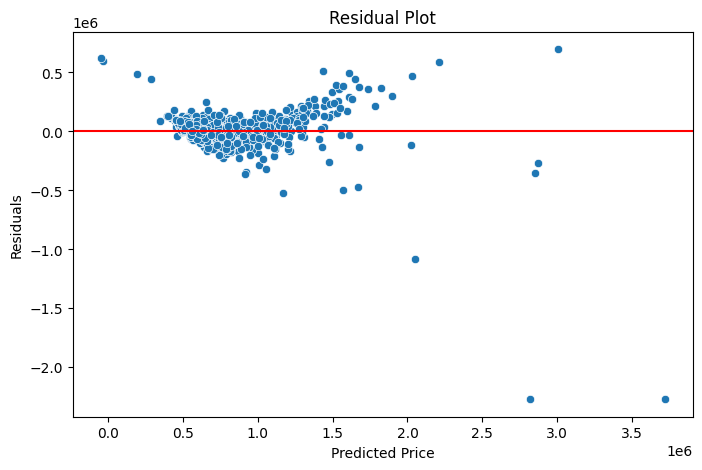

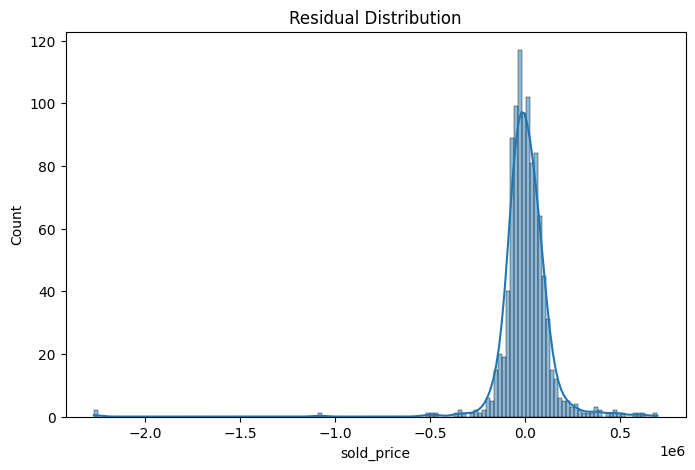

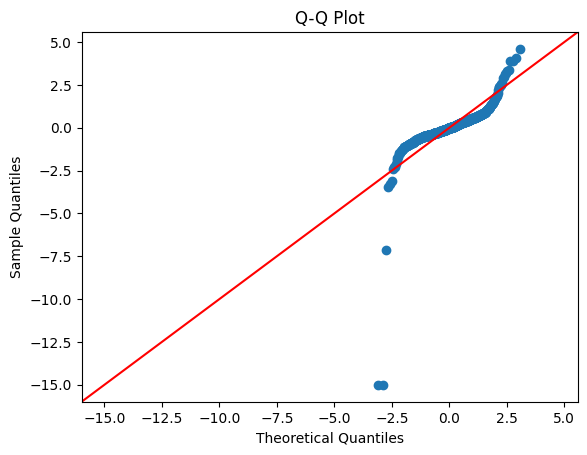

In [4]:
# -------------------------------------------------------------
# 1. Imports
# -------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# -------------------------------------------------------------
# 2. Load data
# -------------------------------------------------------------
df = pd.read_csv("/content/drive/MyDrive/ds/cleaned_final.csv")

# -------------------------------------------------------------
# 3. Basic cleaning
# -------------------------------------------------------------
df = df.drop(columns=["MLS"])

df['kitchen_features'] = df['kitchen_features'].fillna("Unknown")
df['floor_covering'] = df['floor_covering'].fillna("Unknown")

df['fireplaces'] = df['fireplaces'].apply(lambda x: 0 if str(x).lower() in ["none", "0"] else 1)
df['price/sqrft'] = round(df['sold_price']/df['sqrt_ft'], 2)
df['cat'] = price_sq(df['price/sqrft'])
# -------------------------------------------------------------
# 4. Define target
# -------------------------------------------------------------
target = "sold_price"
y = df[target]


# -------------------------------------------------------------
# 5. Nonlinear FIX — log transforms with fallback
# -------------------------------------------------------------
log_transform_cols = ["lot_acres", "taxes", "bedrooms", "bathrooms", "sqrt_ft"]

for col in log_transform_cols:
    if col in df.columns:
        if (df[col] > 0).all():
            df[col + "_log"] = np.log1p(df[col])
        else:
            df[col + "_log"] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())


# -------------------------------------------------------------
# 6. Feature Selection — compute top 3 correlated numeric features
# -------------------------------------------------------------
class SimpleLinearReg:
    def fit(self, X, y):
        X_flat = X.flatten()
        self.w1 = np.cov(X_flat, y)[0, 1] / np.var(X_flat)
        self.w0 = np.mean(y) - self.w1 * np.mean(X_flat)

    def predict(self, X):
        return self.w1 * X + self.w0







# -------------------------------------------------------------
# 7. Rebuild the model features
# -------------------------------------------------------------
categorical_features = ["kitchen_features", "floor_covering"]
numeric_features = ['bathrooms','sqrt_ft','cat']

X = df[numeric_features + categorical_features]


# -------------------------------------------------------------
# 8. Train-test split
# -------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# -------------------------------------------------------------
# 9. Preprocessing
# -------------------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


# -------------------------------------------------------------
# 10. OLS Model (Statsmodels)
# -------------------------------------------------------------
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_array = X_train_processed.toarray()
X_test_array = X_test_processed.toarray()

# add constant
X_train_sm = sm.add_constant(X_train_array)
X_test_sm = sm.add_constant(X_test_array, has_constant='add')

ols_model = sm.OLS(y_train, X_train_sm).fit()

print(ols_model.summary())


# -------------------------------------------------------------
# 11. Predictions
# -------------------------------------------------------------
y_pred = ols_model.predict(X_test_sm)


# -------------------------------------------------------------
# 12. Metrics
# -------------------------------------------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.0f}")
print(f"R² Score: {r2:.4f}")


# -------------------------------------------------------------
# 13. Residual diagnostics
# -------------------------------------------------------------
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot")
plt.show()
